# Project: Forecasting Air Quality Using Historical Pollution Data 

## Step 1: Import All Required Libraries

In [1]:
# Data Handling & Preprocessing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Feature Engineering & ML Models
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Time Series Forecasting Models
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from xgboost import XGBRegressor

# Deep Learning (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Web Interface
import streamlit as st

# Optional: API Data Collection
import requests
import json


## Step2: Loading the dataset

In [3]:
try:
    df = pd.read_csv('city_day.csv')
except FileNotFoundError:
    print("Error: 'city_day.csv' not found.")
    raise

# Display basic information
print("\nFirst 5 Rows:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())


First 5 Rows:
        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  

Missing Values:
City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           103

## Step3: EDA

In [11]:
print("Initial Dataset Shape:", df.shape)

# Convert Date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Convert numeric columns with string numbers (e.g., '1,000') to numeric
def convert_str_to_numeric(col):
    if df[col].dtype == 'object':
        df[col] = df[col].replace(',', '', regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

numeric_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
                'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']

for col in numeric_cols:
    convert_str_to_numeric(col)

# 1. Handle Negative Values
for col in numeric_cols:
    if (df[col] < 0).any():
        df[col] = df[col].clip(lower=0)

# 2. Handle Duplicates
initial_duplicates = df.duplicated(subset=['City', 'Date']).sum()
df = df.drop_duplicates(subset=['City', 'Date'], keep='first')
print(f"Removed {initial_duplicates} duplicate rows.")

# 3. Handle Future Dates
current_date = pd.to_datetime('2025-10-12')
future_dates = df[df['Date'] > current_date]
df = df[df['Date'] <= current_date]
print(f"Removed {len(future_dates)} rows with future dates.")

# 4. Handle Missing Values
# Fill missing values: city-wise median, fallback to global median
for col in numeric_cols:
    global_median = df[col].median()
    
    def safe_fill(x):
        city_median = x.median()
        if np.isnan(city_median):
            return x.fillna(global_median)
        else:
            return x.fillna(city_median)

    df[col] = df.groupby('City')[col].transform(safe_fill)

# Fill missing AQI_Bucket with 'Unknown'
if 'AQI_Bucket' in df.columns:
    df['AQI_Bucket'] = df['AQI_Bucket'].fillna('Unknown')

# 5. Outlier Detection and Capping (IQR method)
def cap_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers_before = ((df[column] < lower) | (df[column] > upper)).sum()
    df[column] = df[column].clip(lower=lower, upper=upper)
    return outliers_before

print("\nOutlier Summary:")
for col in numeric_cols:
    count = cap_outliers(col)
    print(f"{col}: {count} outliers capped.")

# 6. Final Cleaned Data Summary
print("\nFinal Dataset Shape:", df.shape)
print("\nMissing Values After Cleaning:")
print(df.isnull().sum())

# 7. Save Cleaned Data
try:
    df.to_csv('city_day_cleaned.csv', index=False)
    print("\nCleaned dataset saved as 'city_day_cleaned.csv'")
except Exception as e:
    print("Error saving cleaned data:", e)

# 8. Dataset Overview
print("\nFinal Dataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())


Initial Dataset Shape: (29531, 16)
Removed 0 duplicate rows.
Removed 0 rows with future dates.

Outlier Summary:
PM2.5: 0 outliers capped.
PM10: 0 outliers capped.
NO: 0 outliers capped.
NO2: 0 outliers capped.
NOx: 0 outliers capped.
NH3: 0 outliers capped.
CO: 0 outliers capped.
SO2: 0 outliers capped.
O3: 0 outliers capped.
Benzene: 0 outliers capped.
Toluene: 0 outliers capped.
Xylene: 0 outliers capped.
AQI: 0 outliers capped.

Final Dataset Shape: (29531, 16)

Missing Values After Cleaning:
City          0
Date          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI           0
AQI_Bucket    0
dtype: int64

Cleaned dataset saved as 'city_day_cleaned.csv'

Final Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
--

## Step4: Convert Categorical to Numerical (Label Encoding)

In [7]:
import pandas as pd
df = pd.read_csv('city_day_cleaned.csv')
from sklearn.preprocessing import LabelEncoder

# 1. Detect categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("\n=== Categorical Columns Before Encoding ===")
print(cat_cols)

print("\n=== Data Types Before Encoding ===")
print(df.dtypes[cat_cols])

# 2. Preview before encoding
print("\n=== Sample Data Before Encoding ===")
print(df[cat_cols].head())

# 3. Apply Label Encoding
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# 4. Confirm encoding
print("\n=== Sample Data After Encoding ===")
print(df[cat_cols].head())

print("\n=== Data Types After Encoding ===")
print(df.dtypes[cat_cols])



=== Categorical Columns Before Encoding ===
['City', 'Date', 'AQI_Bucket']

=== Data Types Before Encoding ===
City          object
Date          object
AQI_Bucket    object
dtype: object

=== Sample Data Before Encoding ===
        City        Date AQI_Bucket
0  Ahmedabad  01-01-2015       Poor
1  Ahmedabad  02-01-2015  Very Poor
2  Ahmedabad  03-01-2015     Severe
3  Ahmedabad  04-01-2015    Unknown
4  Ahmedabad  05-01-2015    Unknown

=== Sample Data After Encoding ===
   City  Date  AQI_Bucket
0     0     0           2
1     0    67           6
2     0   133           4
3     0   199           5
4     0   265           5

=== Data Types After Encoding ===
City          int64
Date          int64
AQI_Bucket    int64
dtype: object


## Step5: Data Visualization

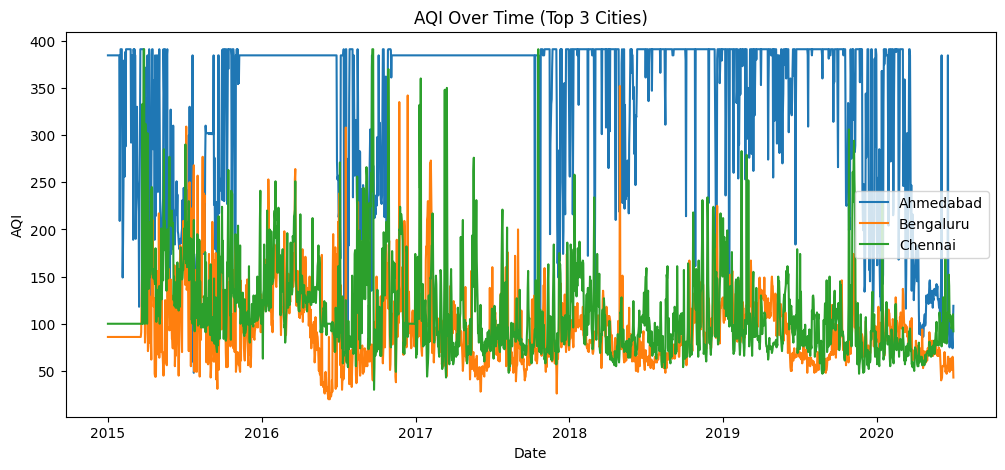

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("city_day_cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Define pollutants list used in the heatmap
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']  # adjust as per your dataset

# Plot: AQI over time for top 3 cities
top_cities = df['City'].value_counts().nlargest(3).index
plt.figure(figsize=(12, 5))
for city in top_cities:
    city_df = df[df['City'] == city]
    plt.plot(city_df['Date'], city_df['AQI'], label=city)
plt.title('AQI Over Time (Top 3 Cities)')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()

Please select a city from the following list:
Ahmedabad, Aizawl, Amaravati, Amritsar, Bengaluru, Bhopal, Brajrajnagar, Chandigarh, Chennai, Coimbatore, Delhi, Ernakulam, Gurugram, Guwahati, Hyderabad, Jaipur, Jorapokhar, Kochi, Kolkata, Lucknow, Mumbai, Patna, Shillong, Talcher, Thiruvananthapuram, Visakhapatnam
Enter city name:  Kochi
Please select a variable from the following list:
PM2.5, PM10, NO, NO2, NOx, NH3, CO, SO2, O3, Benzene, Toluene, Xylene, AQI
Enter variable name:  O3


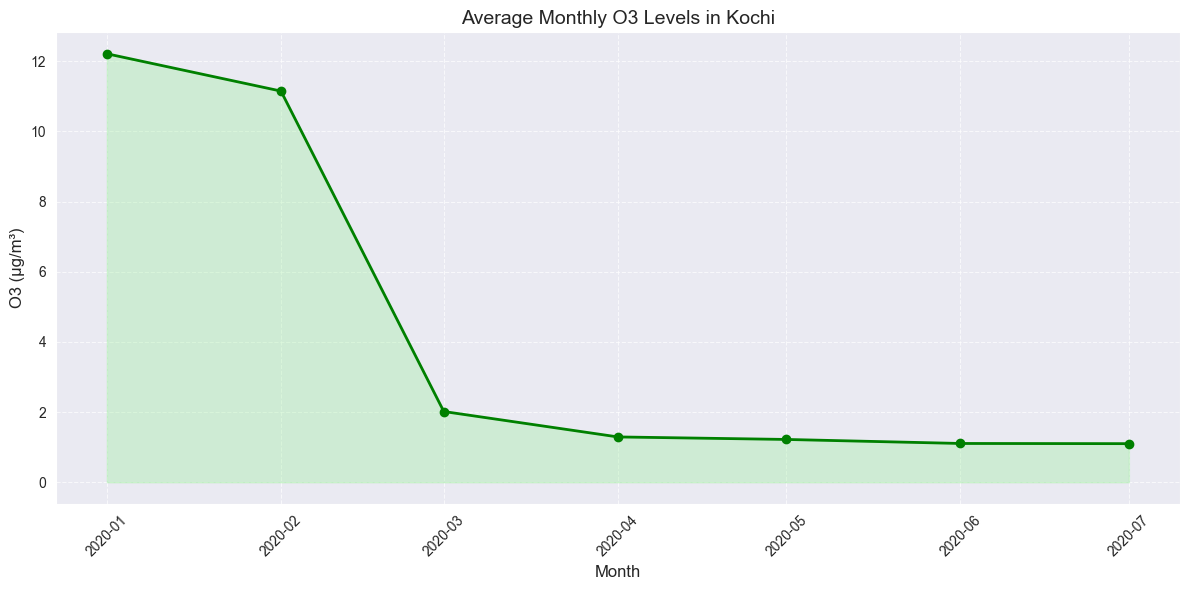

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set visualization style using Seaborn
sns.set_style('darkgrid')
%matplotlib inline

# %% [markdown]
# ## 1. Load the Dataset

# %% [code]
# Load the cleaned dataset with error handling
try:
    df = pd.read_csv('city_day_cleaned.csv')
except FileNotFoundError:
    print("Error: 'city_day_cleaned.csv' not found. Please ensure the file is in the working directory.")
    raise

# Validate data (check for negative values in numerical columns)
numeric_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 
                'Benzene', 'Toluene', 'Xylene', 'AQI']
for col in numeric_cols:
    if (df[col] < 0).any():
        print(f"Warning: Negative values found in {col}. Setting to 0.")
        df[col] = df[col].clip(lower=0)

# %% [markdown]
# ## 2. User Input Selection

# %% [code]
# List of cities and variables
cities = ['Ahmedabad', 'Aizawl', 'Amaravati', 'Amritsar', 'Bengaluru', 'Bhopal', 'Brajrajnagar', 
          'Chandigarh', 'Chennai', 'Coimbatore', 'Delhi', 'Ernakulam', 'Gurugram', 'Guwahati', 
          'Hyderabad', 'Jaipur', 'Jorapokhar', 'Kochi', 'Kolkata', 'Lucknow', 'Mumbai', 'Patna', 
          'Shillong', 'Talcher', 'Thiruvananthapuram', 'Visakhapatnam']

variables = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 
             'Benzene', 'Toluene', 'Xylene', 'AQI']

# Prompt user for input
selected_city = input("Please select a city from the following list:\n" + ", ".join(cities) + "\nEnter city name: ")
while selected_city not in cities:
    print("Invalid city name. Please select from the list.")
    selected_city = input("Please select a city from the following list:\n" + ", ".join(cities) + "\nEnter city name: ")

selected_variable = input("Please select a variable from the following list:\n" + ", ".join(variables) + "\nEnter variable name: ")
while selected_variable not in variables:
    print("Invalid variable name. Please select from the list.")
    selected_variable = input("Please select a variable from the following list:\n" + ", ".join(variables) + "\nEnter variable name: ")

# Filter data based on selected city
city_data = df[df['City'] == selected_city].copy()

# Convert Date to datetime if not already
city_data['Date'] = pd.to_datetime(city_data['Date'], errors='coerce')

# Extract Month and Year for grouping
city_data['Year'] = city_data['Date'].dt.year
city_data['Month'] = city_data['Date'].dt.month

# %% [markdown]
# ## 3. Compute Monthly Averages

# %% [code]
# Compute monthly average for the selected variable
monthly_avg = city_data.groupby(['Year', 'Month'])[selected_variable].mean().reset_index()

# Combine Year and Month for plotting (optional: year-month format)
monthly_avg['Month_Year'] = pd.to_datetime(monthly_avg[['Year', 'Month']].assign(DAY=1))

# Sort by date
monthly_avg = monthly_avg.sort_values('Month_Year')

# %% [markdown]
# ## 4. Time Series Visualization (Monthly Average)

# %% [code]
plt.figure(figsize=(12, 6))

# Plot monthly average points with a line
plt.plot(monthly_avg['Month_Year'], monthly_avg[selected_variable], color='green', marker='o', 
         linewidth=2, markersize=6)

# Fill area under the curve
plt.fill_between(monthly_avg['Month_Year'], monthly_avg[selected_variable], color='lightgreen', alpha=0.3)

# Labels and title
plt.title(f'Average Monthly {selected_variable} Levels in {selected_city}', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel(f'{selected_variable} (µg/m³)' if selected_variable in numeric_cols else selected_variable, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis for month-year display
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



## Step6: Spliting the data into train and test using SK Learn

In [16]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
features = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
X = df[features]
y = df['AQI']

# Split data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (20671, 6)
Test set size: (8860, 6)


# Why XGBoost is Best for This Project

XGBoost is a strong and reliable model for predicting AQI based on multiple pollutants. Here's why it's a better choice compared to other models:

## XGBoost – Advantages

- **Handles many inputs well**  
  Can use multiple pollutant features (PM2.5, PM10, NO2, etc.) at once.

- **High accuracy**  
  Often gives better performance than simple models like ARIMA.

- **Fast and efficient**  
  Trains quickly, even on large datasets.

- **Supports missing data**  
  Can handle missing values better than most models.

## Other Models – Limitations

### ARIMA
- Only uses past AQI values — can't use pollutant inputs.

  > This is a major limitation because in air quality forecasting, pollutant levels like PM2.5, NO2, etc., are important predictors of AQI. ARIMA ignores this valuable information.

### Prophet
- Limited use of other inputs like pollutants.

  > Prophet focuses mainly on time-based trends and seasonality, making it less effective when external features (like pollution levels) play a big role in AQI prediction.

### LSTM (Long Short-Term Memory)
- Requires a lot of data and computation.

  > LSTM models need large datasets and significant computing power to perform well, which can be a challenge if your data is limited or your system is not optimized for deep learning.
